In [1]:
#matファイルから入力ファイルを読み込み
from scipy.io import loadmat
import scipy.io

#mat = loadmat("dataset/dataset_for_accuracy/sample1_var001.mat")
mat = loadmat("dataset/dataset_for_accuracy/sample1.mat")

data = mat['sample']
#print(data[1])

In [2]:
#matファイルから答えのファイルを読み込み
from scipy.io import loadmat
import scipy.io


answer_mat = loadmat("dataset/answer/answer1.mat")
#answer_mat = loadmat("th5/)

#print(answer_mat)
data_answer = answer_mat['answer']
#print(data_answer[0])
#print(data_answer[1])
#print(data_answer[2])

関数

In [5]:
import numpy as np
import copy

#データセットの正規化を行う関数
def standardization(data,dataset):
    
    #正規化したデータを格納するリスト
    standard_data = []
    
    for i in range(dataset[0]):
        
        #最大値，最小値の取得
        max_value = max(data[i])
        min_value = min(data[i])
        
        #正規化したデータを仮に格納しておくリスト
        temp =[]
        
        #データセットの数だけ正規化を行う
        for j in range(dataset[1]):
            temp.append((data[i][j] - min_value)/(max_value - min_value))
        
        standard_data.append(temp)
            
    return standard_data      

#-----------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------

#データセットの離散化を行う関数
import pandas as pd

def discretization(data,dataset,level):
    
    #離散化したデータを格納するリスト
    discretiza_data = []

    #データセットの数だけ離散化を行う
    for i in range(dataset[0]):
        discretiza_data.append(pd.cut(data[i],level,labels=False))
        
    return discretiza_data

#-----------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------

#エピソードマイニングを行う関数
def episode_mining2(win,th,data,dataset):
    
    #候補エピソードを格納するための変数
    candidacy_of_episode = []
    
    #候補エピソードを数える変数
    count_of_candidacy = {}
    
    #一番長いエピソードの長さを格納
    global length
    length = [[] for _ in range(dataset[0])]
    
    #エピソード数がthを超えるものを格納
    occurr = {}
    
    occurr_episode = [[] for _ in range(dataset[0])]
    
    
    #エピソードマイニング部分
    for i in range(dataset[0]):
        for j in range(1,win+1):
            #print(j)
            #長さ1のエピソードの場合
            if j == 1:
                for k in range(dataset[1]):
                    #エピソードの出現した場所を格納しておく
                    count_of_candidacy.setdefault(data[i][k],[]).append(k)

            #長さが2以上のエピソードの場合
            else :
                for k in range(dataset[1] - j + 1):
                    count_of_candidacy.setdefault(tuple(data[i][k:k+j]),[]).append(k)
        
        #エピソードがthの数を超えるかを判定
        occurr = {key:value for key, value in count_of_candidacy.items() if len(value) > th}
        
        #print(len(occurr))
        #一番長いエピソードを取得
        length[i] = len(list(occurr.keys())[-1])
        #print(length[i])
        
        occurr_episode[i].append(occurr)
        
        #初期化
        count_of_candidacy = {}
        occurr = {}
    
    #print(occurr)
    return occurr_episode

#-----------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------

#ラベル付けを行う関数
def labeling(length_of_interval,dataset,episode):
    
    global length
    
    #エピソードの数を格納する変数
    number_of_episode = 0
    
    #ラベル付けしたエピソードを格納する変数
    label_translate = {
        'number_start': -1,
        'number_end' : -1,
        'label' : 0,
    }
    
    #ラベル付けしたエピソードを格納する変数
    labeled_sequence = [[] for _ in range(dataset[0])]
    
    #エピソード番号
    labeled_number = 1
    
    #各系列を回すループ
    for i in range(dataset[0]):
        
        labeled_sequence[i] = [0]*dataset[1]
        
        #パターンの長さをwin/2からwinまで回すループ
        for j in range(length_of_interval,length[i]+1):
            #パターンの長さが1の時は型で認識
            if j == 1:
                number_of_episode = ({key:value for key,value in episode[i][0].items() if type(key) == np.int64})
            #パターンの長さが2以上の時はタプルの長さで認識
            else :
                number_of_episode = ({key:value for key,value in episode[i][0].items() if type(key) != np.int64 and len(list(key)) == j})
            
            #number_of_episodeは｛key(パターン):value(パターンのある場所)｝
            #print(f"number_of_ep{number_of_episode}")
            
            #長さjのエピソードをすべて見ていくループ
            #for k in range(len(number_of_episode)):
            
            #パターンの数だけループさせる
            for k in number_of_episode.values():
                #同じパターンの数ループさせる
                for epi in range(len(k)):
                    
                    #エピソードの開始位置、終了位置の取得
                    label_translate['number_start'] = k[epi]
                    label_translate['number_end'] = k[epi] + j - 1
                    label_translate['label'] = labeled_number
                    
                    #開始・終了位置とエピソード番号をまとめる(ラベル付け)
                    temp = copy.deepcopy(label_translate)
                    #print(temp)
                    #ラベル付けした変数を格納する
                    for number in range(label_translate['number_start'],label_translate['number_end']+1):
                        labeled_sequence[i][number] = labeled_number

                #print(f"labeled_sequence{labeled_sequence}")
                labeled_number += 1
                
    #print(f"labeled_sequence{labeled_sequence}")
    return labeled_sequence

#-----------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------

#区間グラフを抽出する関数
def interval_graph(dataset,labeled_data):
    
    #区間グラフの数を格納
    count_of_interval_graph = -1
    
    #区間グラフの要素の数を格納
    member_of_interval_graph = 0
    
    #区間グラフを一時的に保存する変数
    temp = []
    
    #区間グラフの頂点要素の開始地点を記憶するため、常に開始地点
    temp_for_searchstartpoint = []
    
    #区間グラフ部分:flag=1、区間グラフではない部分:flag=0 
    flag = 0
    
    #区間グラフの要素の数を格納
    count = 0
    
    #区間グラフを格納する変数
    #interval_graph = [[] for _ in range(3)]
    interval_graph_num = []
    interval_graph_count = []
    interval_graph_seq_num = []
    
    
    #区間グラフを書き込むためのファイル
    fid = open('Interval_Graph_List_py.dat','w')
    
    #区間グラフを抽出するために系列を見ていく
    for j in range(dataset[1]):
        #時間点jの系列がすべて0の場合は処理を行わない
        if sum([row[0] for row in labeled_data]) != 0:
            #時間点jの各系列の値を見る
            for i in range(dataset[0]):
                #系列i、時間点jの要素が0でない場合
                if labeled_data[i][j] != 0:
                    #区間グラフ内の要素の開始地点を記憶するための処理
                    if len(temp) == 0:
                        startpoint = j
                        flag = 1
                        count_of_interval_graph += 1
                        #print(count_of_interval_graph)
                        
                        interval_graph_num.append([])
                        interval_graph_count.append([])
                        interval_graph_seq_num.append([])
                        
                    if flag == 1 and j == 0:
                        if labeled_data[i][j] not in temp_for_searchstartpoint:
                            interval_graph_num[count_of_interval_graph].append({labeled_data[i][j]:j}) #num1
                            interval_graph_count[count_of_interval_graph].append({labeled_data[i][j]:1}) #count
                            interval_graph_seq_num[count_of_interval_graph].append({labeled_data[i][j]:i}) #seq_num
                        else:
                            a = temp_for_searchstartpoint.count(labeled_data[i][j])
                            interval_graph_num[count_of_interval_graph].append({labeled_data[i][j]:j}) #num1
                            interval_graph_count[count_of_interval_graph].append({labeled_data[i][j]:a}) #count
                            interval_graph_seq_num[count_of_interval_graph].append({labeled_data[i][j]:i}) #seq_num
                            
                        temp_for_searchstartpoint.append(labeled_data[i][j])
                        count += 1
                    
                    elif flag == 1 and labeled_data[i][j] != labeled_data[i][j-1] and j > 0:
                        if labeled_data[i][j] not in temp_for_searchstartpoint:
                            interval_graph_num[count_of_interval_graph].append({labeled_data[i][j]:j}) #num1
                            interval_graph_count[count_of_interval_graph].append({labeled_data[i][j]:1}) #count
                            interval_graph_seq_num[count_of_interval_graph].append({labeled_data[i][j]:i}) #seq_num
                        else:
                            a = temp_for_searchstartpoint.count(labeled_data[i][j])
                            interval_graph_num[count_of_interval_graph].append({labeled_data[i][j]:j}) #num1
                            interval_graph_count[count_of_interval_graph].append({labeled_data[i][j]:a}) #count
                            interval_graph_seq_num[count_of_interval_graph].append({labeled_data[i][j]:i}) #seq_num
                            
                        temp_for_searchstartpoint.append(labeled_data[i][j])
                        count += 1
                    
                    if labeled_data[i][j] not in temp:
                        member_of_interval_graph += 1
                        temp.append(labeled_data[i][j])
                    
                    if j == dataset[1]:
                        continuation = 0
                    else:
                        for k in range(dataset[0]):
                            if k == i and labeled_data[k][j + 1] != 0:
                                continuation = 1
                            elif k != i and labeled_data[k][j] != 0 and labeled_data[k][j + 1] != 0:
                                continuation = 1
            
            if continuation == 0:
                #print(temp)
                if len(temp) != 0:
                    temp = sorted(temp)
                    for i in range(len(temp)):
                        fid.write('\t')
                        fid.write(str(temp[i]))
                        
                    #interval_graph.append(temp)
                    fid.write('\n')
                    
                #初期化
                flag = 0
                temp = []
                member_of_interval_graph = 0
                temp_for_searchstartpoint = []
                count = 0
            
            
            #初期化
            continuation = 0
    
    #print(interval_graph)
    fid.close()
    
    #print(interval_graph[0])
    #print(interval_graph[1])
    #print(interval_graph[2])
    
    return [interval_graph_num,interval_graph_count,interval_graph_seq_num]

#-----------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------

def Association_pattern_mining(labeled_sequence,interval_graph,dataset):
    
    #LCM
    !lcm53\lcm.exe CI Interval_Graph_List_py.dat 8 Association_Pattern_py.dat

    #LCMによる出力ファイルを変換
    !java transform
    
    #変換したファイルのうち飽和集合のリストを読み込み
    fid = open('closed_itemset_py.dat','r')
    
    nothing = 0
    
    i = 0
    member = []
    t_id = []
    oc = []
    
    if fid == []:
        nothing = 1;
    else:
        for tline in fid:
            
            tline = tline.strip()
            if tline:
                member.append([int(value) for value in tline.strip().split(' ')])
                #print(member[i])
                i += 1
            
            #member.append([int(value) for value in tline.split(' ')])
            #print(member[i])
            #i += 1
            
    
        number_of_association_pattern = i
    
    fid.close()
    
    #変換したファイルのうちトランザクション番号のリストを読み込み
    fid = open('transaction_id_py.dat','r')
    
    n = 1
    i = 0
    
    if nothing == 1:
        n = 0;
    else:
        for tline in fid:
            tline = tline.strip()
            if tline:
                t_id.append([int(value) for value in tline.strip().split(' ')])
                oc.append(len(t_id[i]))
                #print(t_id[i])
                i += 1
            
            #t_id.append([int(value) for value in tline.split(' ')])
            #oc.append(len(t_id[i]))
            #print(t_id[i])            
            #i += 1
    
    fid.close()
    
    #連関パタン（0と1で表現）を格納するリスト
    association_pattern_sequence = [0] * dataset[1]
    
    #飽和集合の数だけループ
    for i in range(number_of_association_pattern):
        
        #飽和集合のi番目のリストを格納
        member_of_association_pattern = []
        member_of_association_pattern = member[i]
        
        #飽和集合のリストのサイズを格納
        size_of_association_pattern = len(member_of_association_pattern)
        
        #トランザクション番号を格納
        transaction_id = []
        transaction_id = t_id[i]
        
        #トランザクション番号のリストのサイズを格納
        occur = 0
        occur = oc[i]
        
        #トランザクション番号のサイズ分ループ
        for j in range(occur):
            #print(size_of_association_pattern)
            #飽和集合のリストのサイズ分ループ
            for k in range(size_of_association_pattern):
                seq_num = 0
                #print(member_of_association_pattern[k])
                seq_num = [d[member_of_association_pattern[k]] for d in interval_graph[2][transaction_id[j]] if member_of_association_pattern[k] in d]#何個目の系列のデータなのかを格納
                #print(seq_num[0])
                if seq_num == []:
                    break
                
                occur_in_ig = 0
                occur_in_ig = [d[member_of_association_pattern[k]] for d in interval_graph[1][transaction_id[j]] if member_of_association_pattern[k] in d] #区間グラフの区間の数を格納
                #print(member_of_association_pattern[k])
                #print(k)
                #print(occur_in_ig[0])
                
                for l in range(occur_in_ig[0]):
                    startpoint_of_pattern = 0
                    startpoint_of_pattern = [d[member_of_association_pattern[k]] for d in interval_graph[0][transaction_id[j]] if member_of_association_pattern[k] in d]
                    
                    m = 0
                    while labeled_sequence[seq_num[0]][startpoint_of_pattern[0] + m] == member_of_association_pattern[k]:
                        #print(labeled_sequence[seq_num[0]][startpoint_of_pattern[0] + m])
                        #print(member_of_association_pattern[k])
                        association_pattern_sequence[startpoint_of_pattern[0] + m] = 1
                        m += 1 
                        if startpoint_of_pattern[0] + m > dataset[1]:
                            break
                #print(association_pattern_sequence)
    
    
    #連関パタンの部分を1、それ以外を0とした系列
    return association_pattern_sequence
    

メイン関数

In [6]:
import numpy as np
import math

#データセットのシーケンスの数と、データの長さを取得
size_of_dataset_arr = np.array(data)

size_of_dataset = []
size_of_dataset = size_of_dataset_arr.shape
#print(size_of_dataset)

#正規化
standard_data = standardization(data,size_of_dataset)
#print(standard_data[1])

#離散化
discretiza_level = 50; #何段階に離散化するかの値
discretiza_data  = discretization(standard_data,size_of_dataset,discretiza_level)

#discretization(standard_data,size_of_dataset,discretiza_level)
#print(discretiza_data[0])


#エピソードマイニング（Mannilaアルゴリズム）
win = 5 #頻出パタンの最大ウィンドウ幅
th  = 5 #頻出パタンの最小出現数
#candidacy_of_episode = episode_mining(win,th,discretiza_data,size_of_dataset)
#episode_mining(win,th,discretiza_data,size_of_dataset)
episode = episode_mining2(win,th,discretiza_data,size_of_dataset)
#print(episode[0])
#print(episode[1])
#print(episode[2])


#ラベル付けを行う
#区間と認める最低限の長さ
length_of_interval = math.ceil(win/2)
label_translate = labeling(length_of_interval,size_of_dataset,episode)
#print(label_translate)
#print(label_translate[1])
#print(label_translate[2])

#区間グラフの抽出を行う
interval_graph_data = interval_graph(size_of_dataset,label_translate)        
#print(len(interval_graph_data[0]))
#for i in range(len(interval_graph_data[0])):
#print(interval_graph_data[0][i])
#print(interval_graph_data[1])
#print(interval_graph_data[2])

#連鎖パタンの発見を行う
#LCMで頻出飽和集合をとる
result = Association_pattern_mining(label_translate,interval_graph_data,size_of_dataset)
#print(result)

#precision
#cdp = sum([1 for i in range(len(result)) if result[i] == data_answer[0][i]])

cdp = 0
for a,b in zip(result, data_answer[0]):
    if a==1 and b==1:
        cdp += 1

ddp = result.count(1)
edp = np.count_nonzero(data_answer[0])

precision = cdp/ddp
recall = cdp/edp
f_measure = 2*precision*recall/(precision + recall)

print("EDP = ",edp)
print("DDP = ",ddp)
print("CDP = ",cdp)
print("Precision =", precision)
print("Recall = ", recall)
print("F-measure = ", f_measure)



1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1


trsact: Interval_Graph_List_py.dat ,#transactions 10 ,#items 277 ,size 960 extracted database: #transactions 10 ,#items 96 ,size 960
 output to: Association_Pattern_py.dat
separated at 0
iters=1


EDP =  510
DDP =  510
CDP =  510
Precision = 1.0
Recall =  1.0
F-measure =  1.0


メイン関数（ウィンドウ幅を繰り返す）

In [7]:
import numpy as np
import math

#データセットのシーケンスの数と、データの長さを取得
size_of_dataset_arr = np.array(data)
size_of_dataset = []
size_of_dataset = size_of_dataset_arr.shape
#正規化
standard_data = standardization(data,size_of_dataset)
#離散化
discretiza_level = 50; #何段階に離散化するかの値
discretiza_data  = discretization(standard_data,size_of_dataset,discretiza_level)

#エピソードマイニング（Mannilaアルゴリズム）
win = 10 #頻出パタンの最大ウィンドウ幅
for i in range(3,win + 1):
    
    th  = 3 #頻出パタンの最小出現数
    episode = episode_mining2(i,th,discretiza_data,size_of_dataset)

    #ラベル付けを行う
    #区間と認める最低限の長さ
    length_of_interval = math.ceil(i/2)
    label_translate = labeling(length_of_interval,size_of_dataset,episode)

    #区間グラフの抽出を行う
    interval_graph_data = interval_graph(size_of_dataset,label_translate)        

    #連鎖パタンの発見を行う
    #LCMで頻出飽和集合をとる
    result = Association_pattern_mining(label_translate,interval_graph_data,size_of_dataset)

    cdp = 0
    for a,b in zip(result, data_answer[0]):
        if a==1 and b==1:
            cdp += 1

    ddp = result.count(1)
    edp = np.count_nonzero(data_answer[0])

    precision = cdp/ddp
    recall = cdp/edp
    f_measure = 2*precision*recall/(precision + recall)

    print("win = ",i)
    print("EDP  = ",edp)
    print("DDP = ",ddp)
    print("CDP = ",cdp)
    print("Precision =", precision)
    print("Recall = ", recall)
    print("F-measure = ", f_measure)



2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1


trsact: Interval_Graph_List_py.dat ,#transactions 24 ,#items 169 ,size 887 extracted database: #transactions 24 ,#items 87 ,size 870
 output to: Association_Pattern_py.dat
separated at 0
iters=88


win =  3
EDP  =  510
DDP =  510
CDP =  510
Precision = 1.0
Recall =  1.0
F-measure =  1.0
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1


trsact: Interval_Graph_List_py.dat ,#transactions 24 ,#items 262 ,size 947 extracted database: #transactions 24 ,#items 93 ,size 930
 output to: Association_Pattern_py.dat
separated at 0
iters=94


win =  4
EDP  =  510
DDP =  510
CDP =  510
Precision = 1.0
Recall =  1.0
F-measure =  1.0


trsact: Interval_Graph_List_py.dat ,#transactions 10 ,#items 277 ,size 960 extracted database: #transactions 10 ,#items 96 ,size 960
 output to: Association_Pattern_py.dat
separated at 0
iters=1


1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
win =  5
EDP  =  510
DDP =  510
CDP =  510
Precision = 1.0
Recall =  1.0
F-measure =  1.0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1


trsact: Interval_Graph_List_py.dat ,#transactions 10 ,#items 375 ,size 980 extracted database: #transactions 10 ,#items 98 ,size 980
 output to: Association_Pattern_py.dat
separated at 0
iters=1


win =  6
EDP  =  510
DDP =  510
CDP =  510
Precision = 1.0
Recall =  1.0
F-measure =  1.0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1


trsact: Interval_Graph_List_py.dat ,#transactions 10 ,#items 385 ,size 970 extracted database: #transactions 10 ,#items 97 ,size 970
 output to: Association_Pattern_py.dat
separated at 0
iters=1


win =  7
EDP  =  510
DDP =  510
CDP =  510
Precision = 1.0
Recall =  1.0
F-measure =  1.0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1


trsact: Interval_Graph_List_py.dat ,#transactions 10 ,#items 481 ,size 960 extracted database: #transactions 10 ,#items 96 ,size 960
 output to: Association_Pattern_py.dat
separated at 0
iters=1


win =  8
EDP  =  510
DDP =  510
CDP =  510
Precision = 1.0
Recall =  1.0
F-measure =  1.0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1


trsact: Interval_Graph_List_py.dat ,#transactions 10 ,#items 483 ,size 950 extracted database: #transactions 10 ,#items 95 ,size 950
 output to: Association_Pattern_py.dat
separated at 0
iters=1


win =  9
EDP  =  510
DDP =  510
CDP =  510
Precision = 1.0
Recall =  1.0
F-measure =  1.0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1


trsact: Interval_Graph_List_py.dat ,#transactions 10 ,#items 577 ,size 940 extracted database: #transactions 10 ,#items 94 ,size 940
 output to: Association_Pattern_py.dat
separated at 0
iters=1


win =  10
EDP  =  510
DDP =  510
CDP =  510
Precision = 1.0
Recall =  1.0
F-measure =  1.0


2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1


trsact: Interval_Graph_List_py.dat ,#transactions 10 ,#items 277 ,size 1020 extracted database: #transactions 10 ,#items 102 ,size 1018
 output to: Association_Pattern_py.dat
separated at 0
iters=3


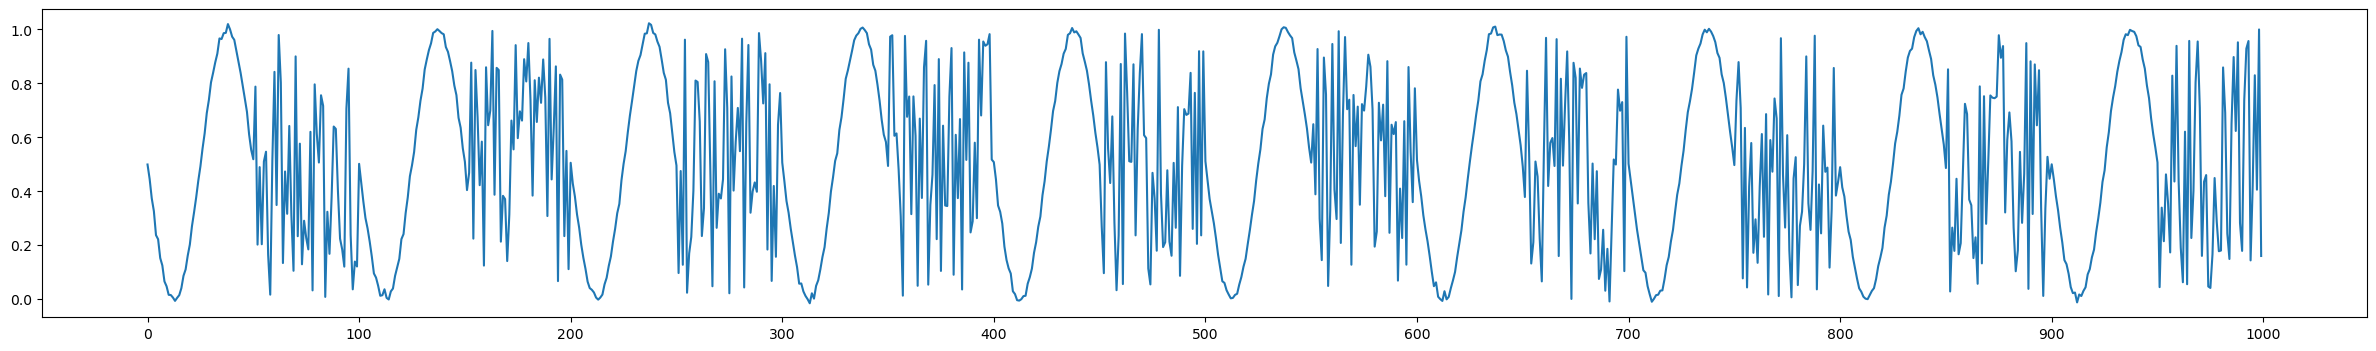

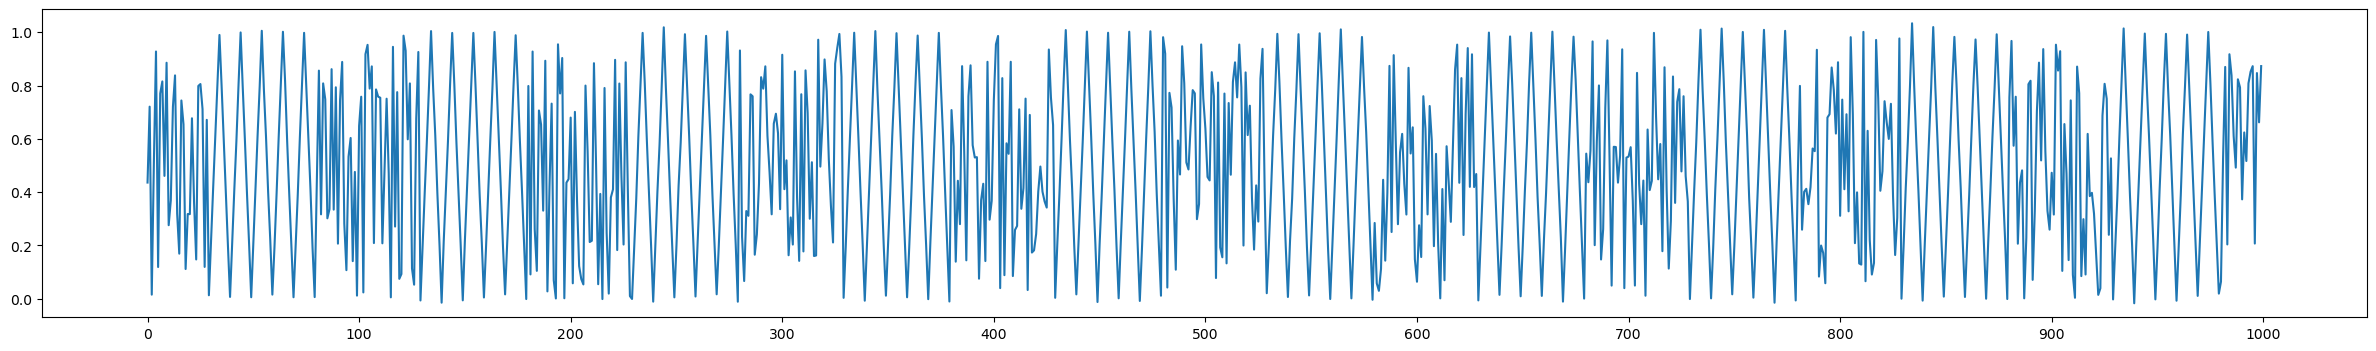

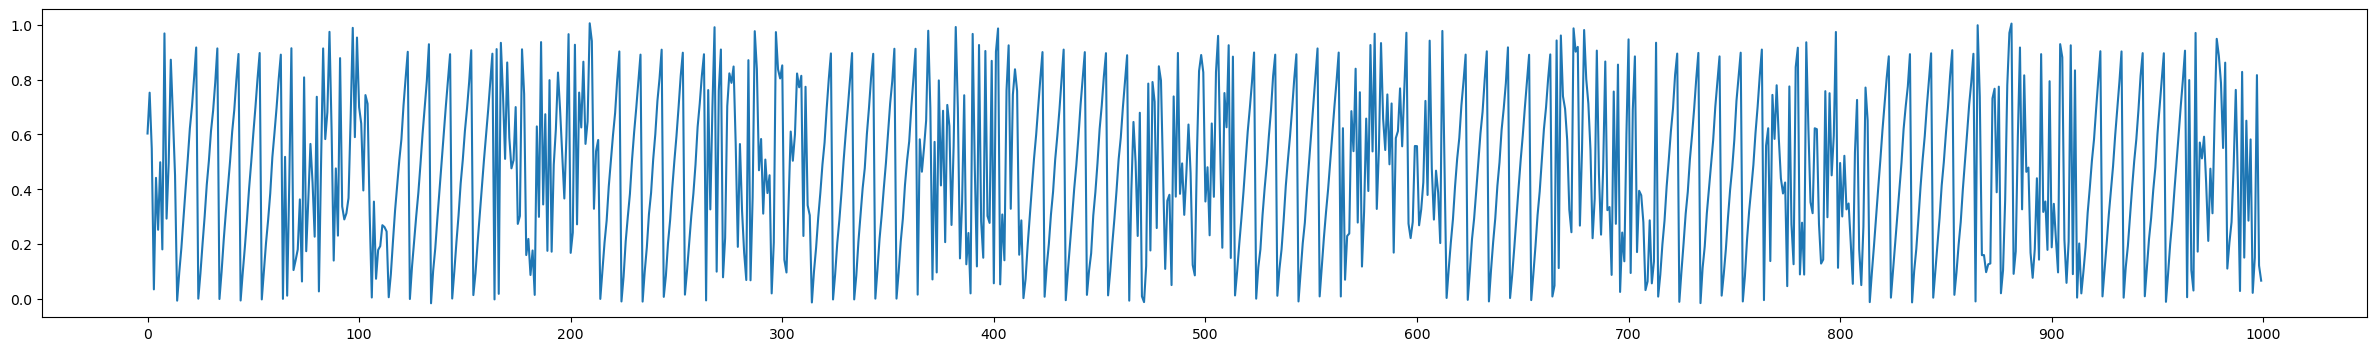

In [21]:
#元データをプロットしたもの
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (30, 4)
plt.plot(data[0])
plt.xticks([0,100,200,300,400,500,600,700,800,900,1000])
plt.show()

plt.rcParams["figure.figsize"] = (30, 4)
plt.plot(data[1])
plt.xticks([0,100,200,300,400,500,600,700,800,900,1000])
plt.show()

plt.rcParams["figure.figsize"] = (30, 4)
plt.plot(data[2])
plt.xticks([0,100,200,300,400,500,600,700,800,900,1000])
plt.show()

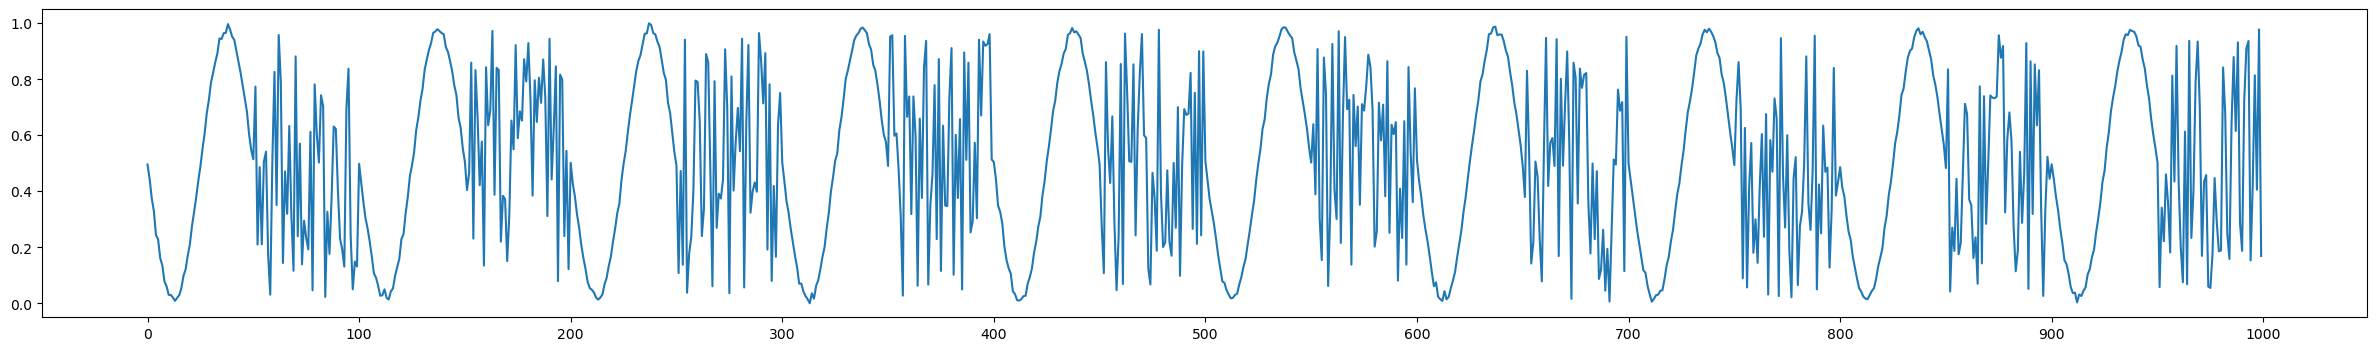

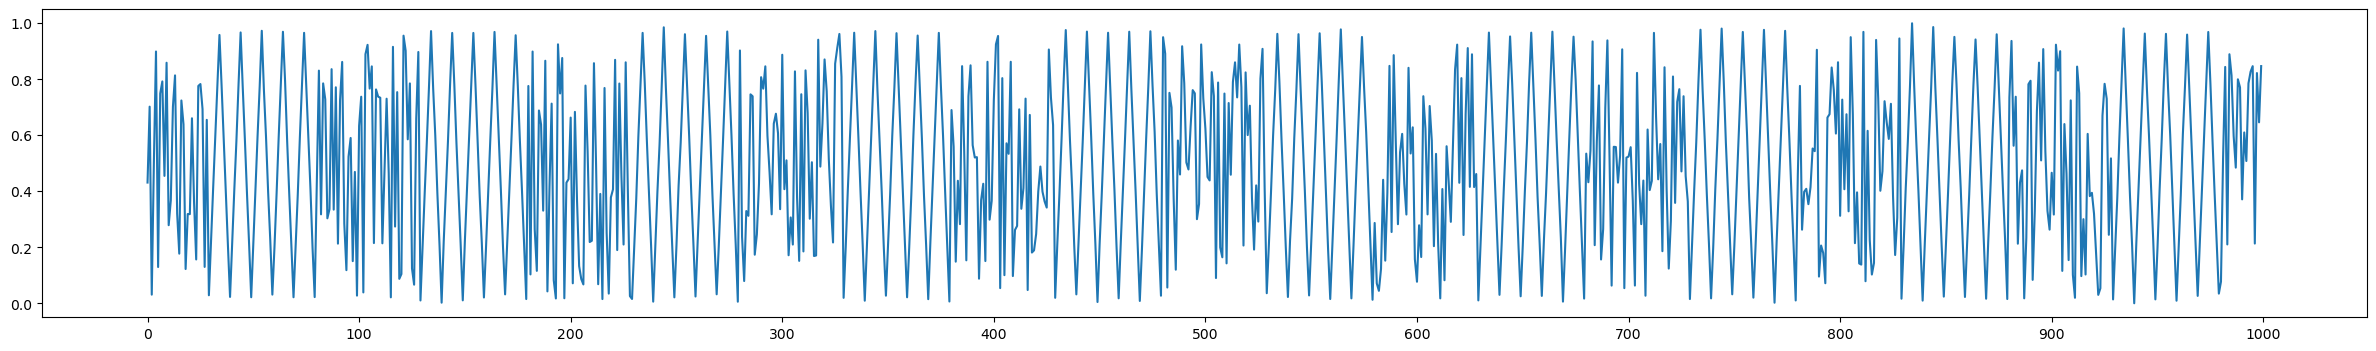

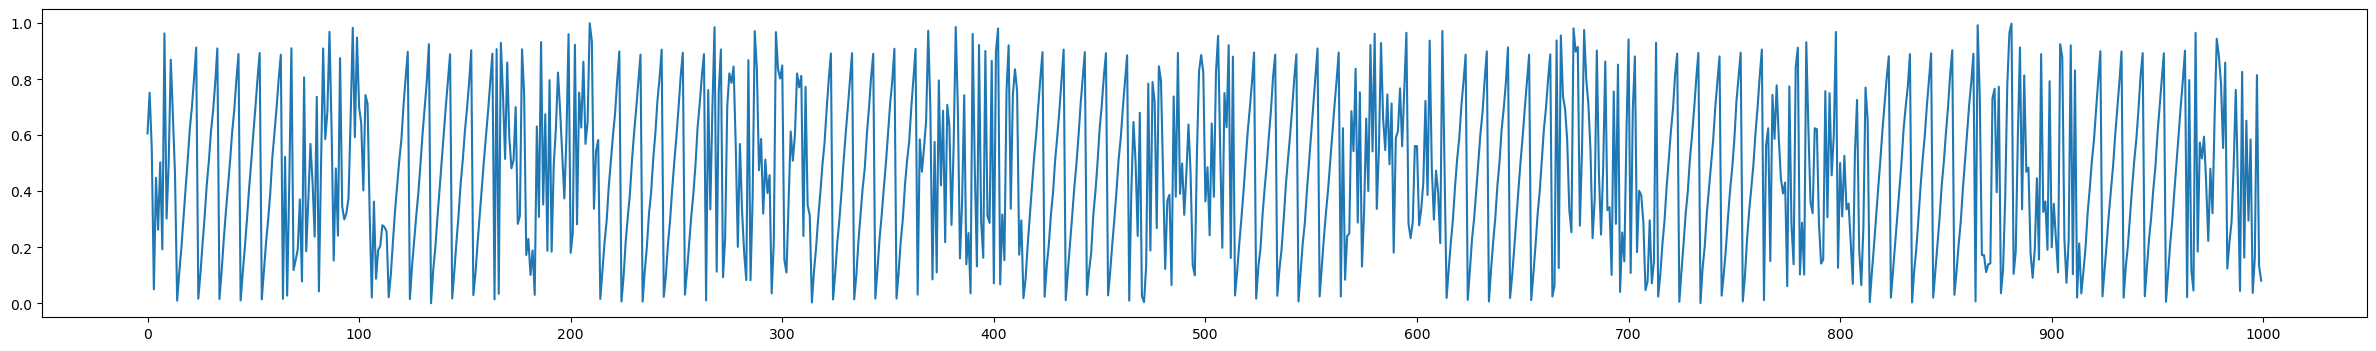

In [22]:
#正規化したデータをプロットしたもの
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (30, 4)
plt.plot(standard_data[0])
plt.xticks([0,100,200,300,400,500,600,700,800,900,1000])
plt.show()

plt.rcParams["figure.figsize"] = (30, 4)
plt.plot(standard_data[1])
plt.xticks([0,100,200,300,400,500,600,700,800,900,1000])
plt.show()

plt.rcParams["figure.figsize"] = (30, 4)
plt.plot(standard_data[2])
plt.xticks([0,100,200,300,400,500,600,700,800,900,1000])
plt.show()

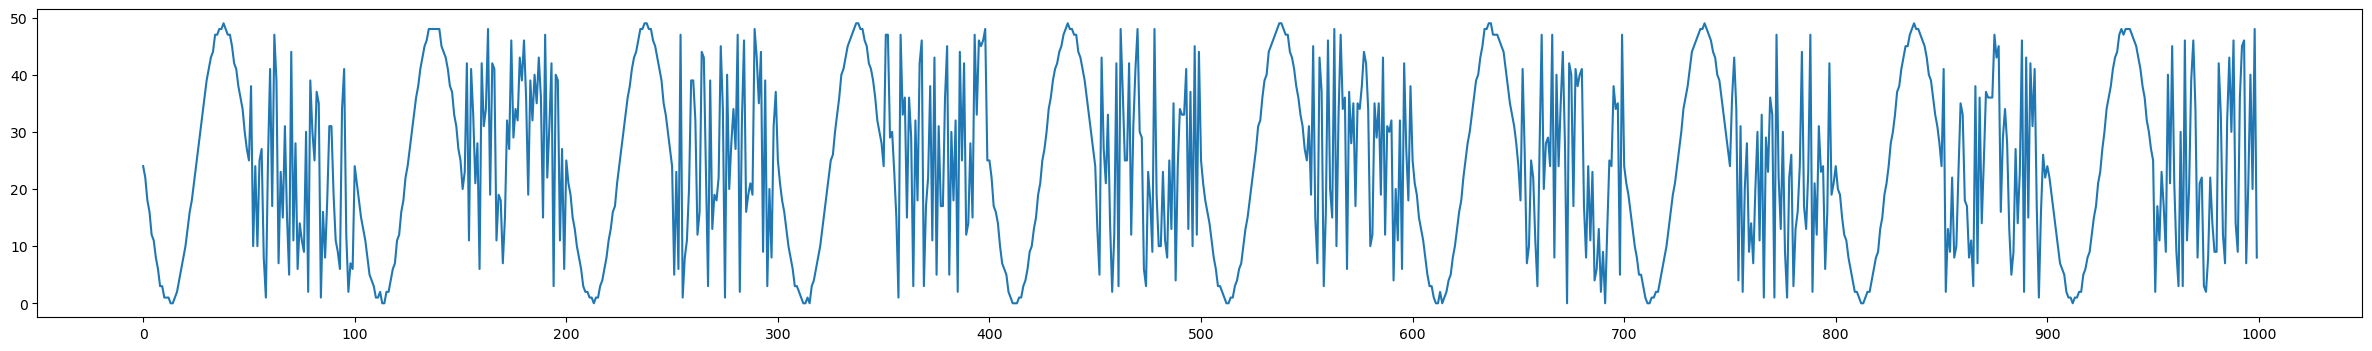

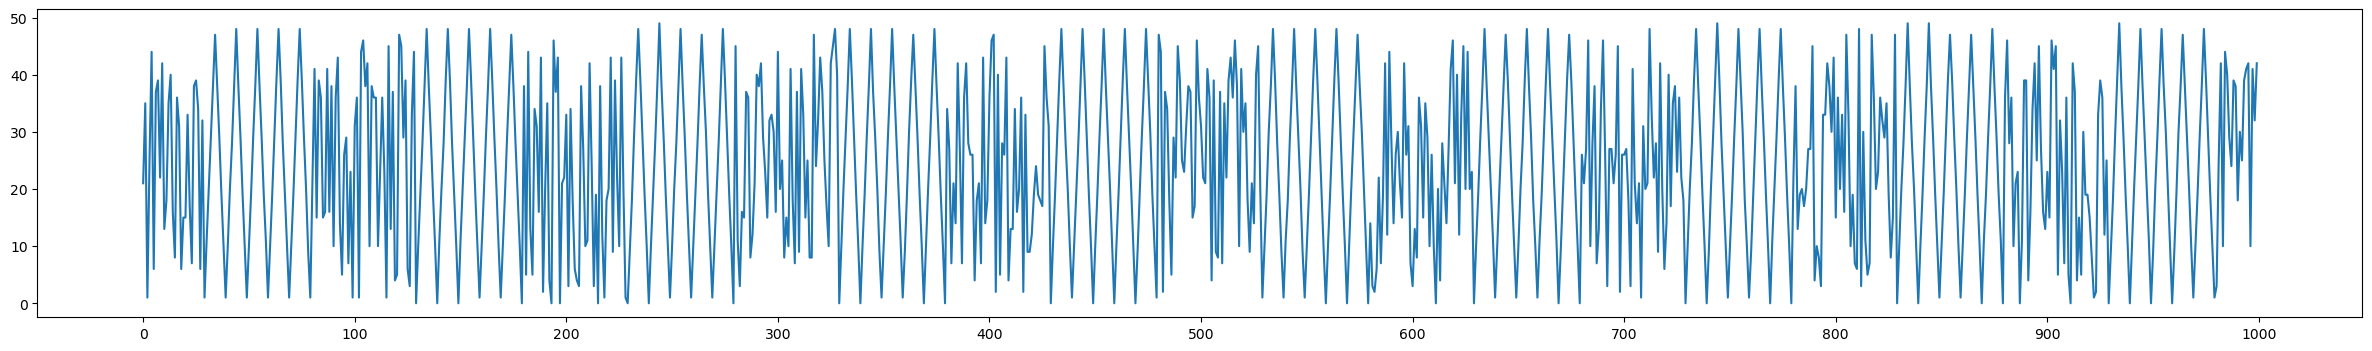

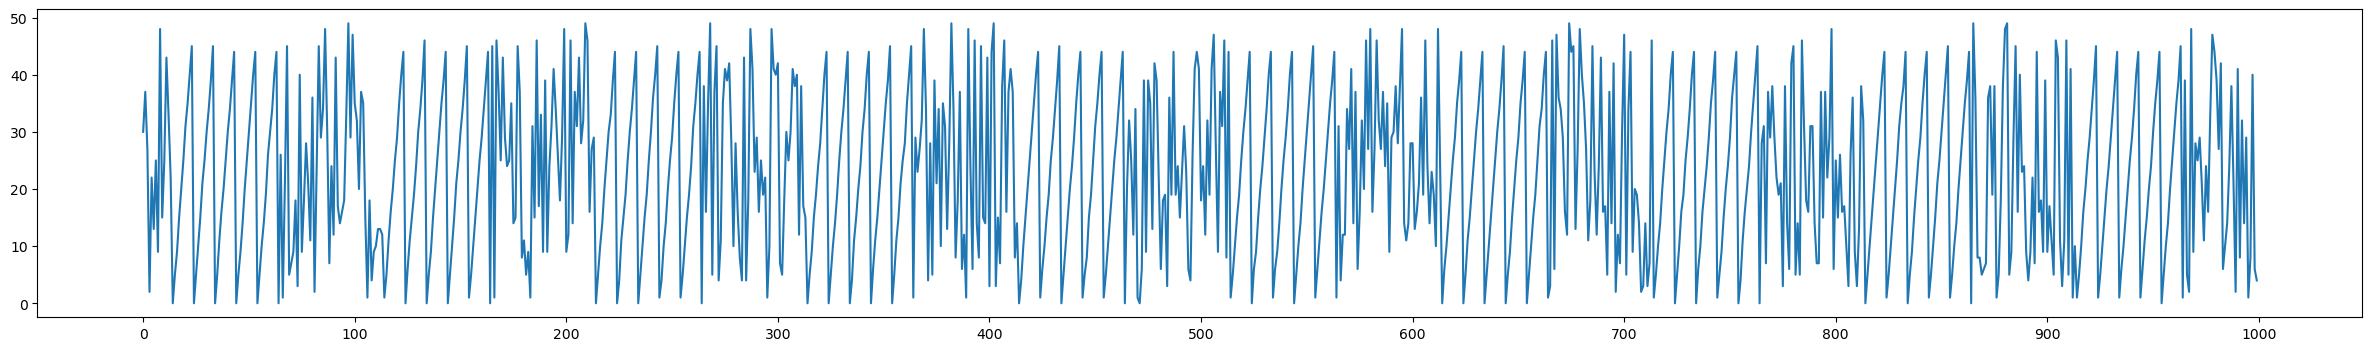

In [23]:
#離散化したデータをプロットしたもの
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (30, 4)
plt.plot(discretiza_data[0])
plt.xticks([0,100,200,300,400,500,600,700,800,900,1000])
plt.show()

plt.rcParams["figure.figsize"] = (30, 4)
plt.plot(discretiza_data[1])
plt.xticks([0,100,200,300,400,500,600,700,800,900,1000])
plt.show()

plt.rcParams["figure.figsize"] = (30, 4)
plt.plot(discretiza_data[2])
plt.xticks([0,100,200,300,400,500,600,700,800,900,1000])
plt.show()

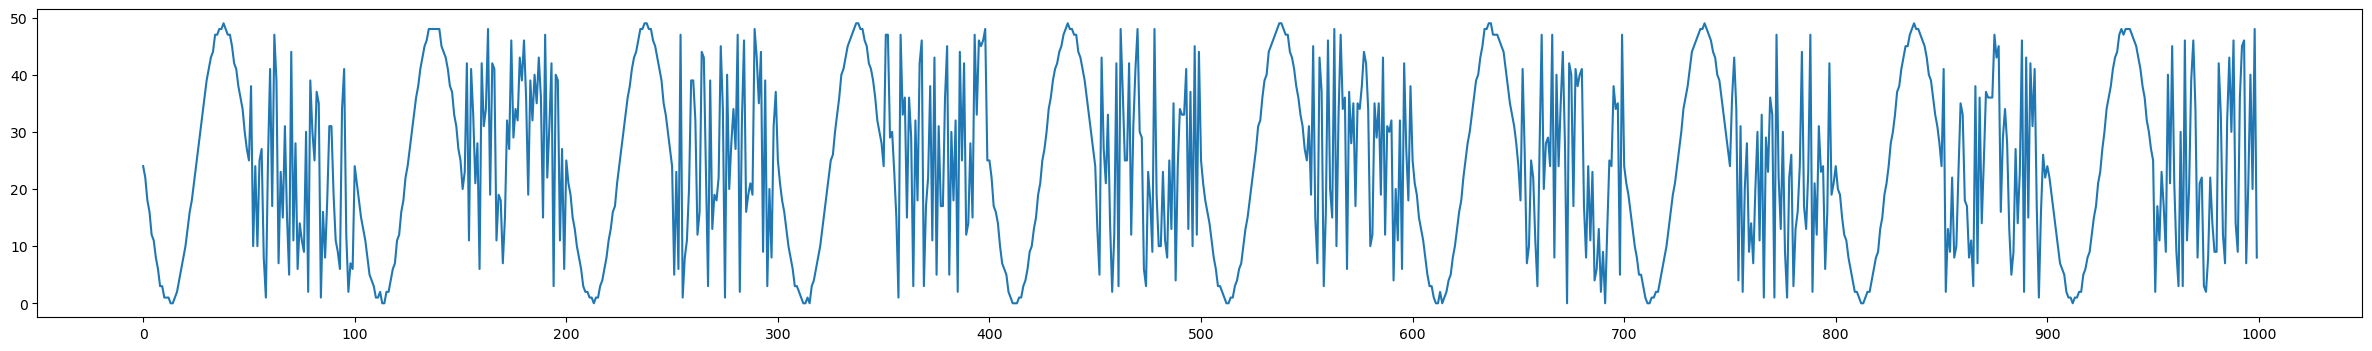

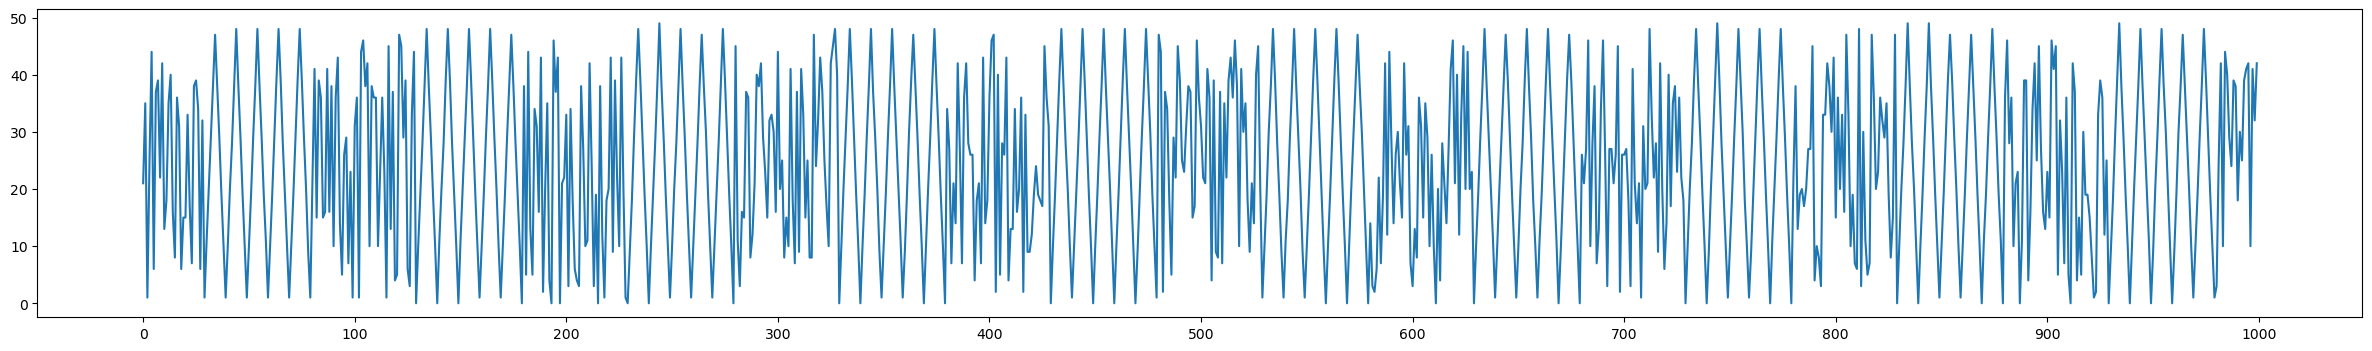

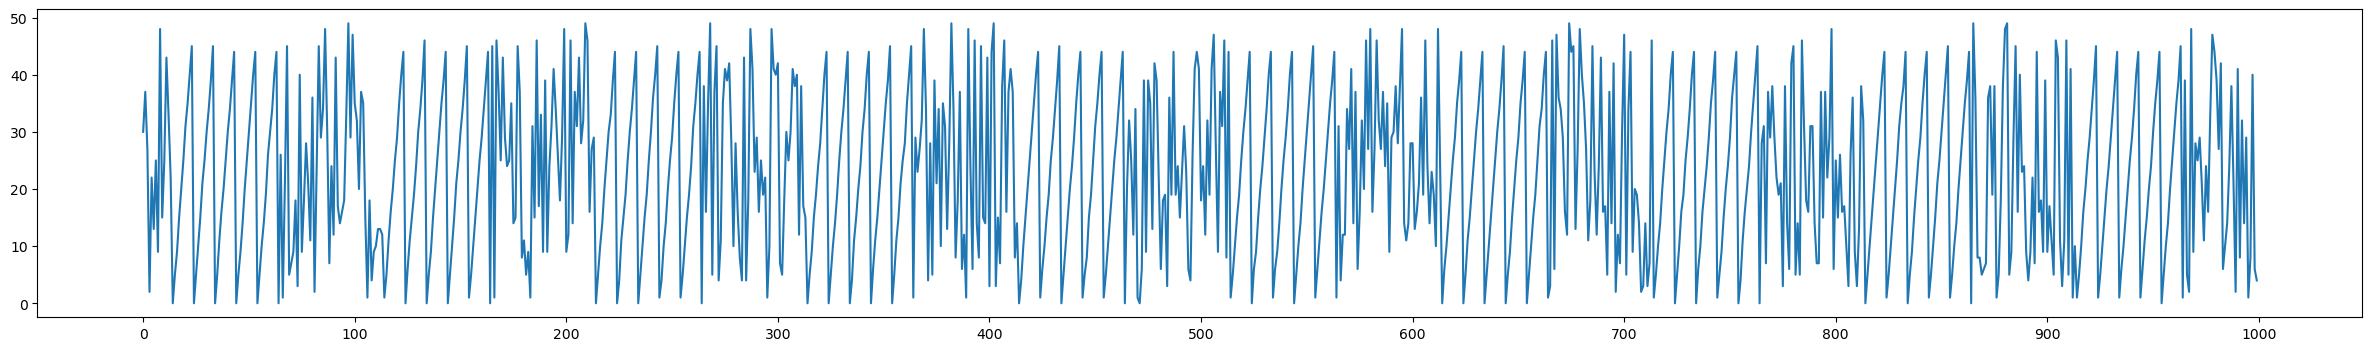

In [23]:
#離散化したデータをプロットしたもの
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (30, 4)
plt.plot(discretiza_data[0])
plt.xticks([0,100,200,300,400,500,600,700,800,900,1000])
plt.show()

plt.rcParams["figure.figsize"] = (30, 4)
plt.plot(discretiza_data[1])
plt.xticks([0,100,200,300,400,500,600,700,800,900,1000])
plt.show()

plt.rcParams["figure.figsize"] = (30, 4)
plt.plot(discretiza_data[2])
plt.xticks([0,100,200,300,400,500,600,700,800,900,1000])
plt.show()